In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import sys; sys.path.insert(0, '../')

import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost

# Core
import numpy as np
import scipy.io as io
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from mlens.ensemble import SuperLearner

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder
from onecyclelr import OneCycleLR
import pcgrad
from pytorch_stats_loss import torch_wasserstein_loss, torch_energy_loss
from geomloss import SamplesLoss
from utils import *

# Model selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from RegscorePy.bic import bic

from tqdm import trange

[MLENS] backend: threading


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Running Python 3.9.9
You can use npar for np.array


In [2]:
DATA_PATH = "../experimental_data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

# Adding noise
noise_intensity = 0.01
noisy_xt = True

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

if noise_intensity>0.0:
    Exact = perturb(Exact, intensity=noise_intensity, noise_type="normal")
    print("Perturbed Exact with intensity =", float(noise_intensity))
else: print("Clean Exact")

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 3000; include_unsup = True
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

if noisy_xt and noise_intensity>0.0:
    print("Noisy (x, t)")
    X_u_train = perturb(X_u_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean (x, t)")

# Unsup data
N_res = N
idx_res = np.array(range(X_star.shape[0]-1))[~idx]
idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
X_res = X_star[idx_res, :]
if include_unsup:
    print(f"Training with {N_res} unsup samples")
    X_u_train = np.vstack([X_u_train, X_res])

# Convert to torch.tensor
X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)
X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)

# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

feature_names=('uf', 'u_x', 'u_xx', 'u_xxx')

Perturbed Exact with intensity = 0.01
Training with 3000 samples
Noisy (x, t)
Training with 3000 unsup samples


In [3]:
class Network(nn.Module):
    def __init__(self, model, index2features=('uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx')):
        super(Network, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking, the default tup is for the burgers' equation.
        self.index2features = index2features
        print("Considering", self.index2features)
        self.diff_flag = diff_flag(self.index2features)
        self.uf = None
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        self.uf = self.model(torch.cat([x, t], dim=1))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        u_x = self.gradients(uf, x)[0]
        u_xx = self.gradients(u_x, x)[0]
        u_xxx = self.gradients(u_xx, x)[0]
        
        return cat(uf, u_x, u_xx, u_xxx), u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

In [4]:
class AttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, prob_activation=torch.sigmoid, bn=None, reg_intensity=1e-3):
        super(AttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = nn.Linear(layers[0], layers[0])
        self.prob_activation = prob_activation
        self.nonlinear_model = TorchMLP(dimensions=layers, activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1))
        self.latest_weighted_features = None
        self.th = (1/layers[0])-(1e-10)
        self.reg_intensity = reg_intensity
        self.w = (0.1)*torch.tensor([1.0, 1.0, 2.0, 3.0])
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn, bi=False):
        if bi: att = binarize(self.weighted_features(inn), self.th)
        else: att = F.threshold(self.weighted_features(inn), self.th, 0.0)
        return self.nonlinear_model(inn*att)
    
    def weighted_features(self, inn):
        self.latest_weighted_features = self.prob_activation(self.linear1(inn)).mean(axis=0)
        return self.latest_weighted_features
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        reg_term = F.relu(self.latest_weighted_features-self.th)
        
        l1 = mse_loss
        l2 = torch.norm(reg_term, p=0)+torch.dot(self.w, reg_term)
        return l1+self.reg_intensity*(l2)

class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
        
    def forward(self, X_u_train):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_u_train))
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        unsup_loss = self.selector.loss(X_selector, y_selector)
        return self.network.uf, unsup_loss

In [5]:
### Version with normalized derivatives ###
# pretrained_state_dict = torch.load('../saved_path_inverse_burger/lbfgsnew_results/semisup_model_with_LayerNormDropout_without_physical_reg_trained250labeledsamples_trained0unlabeledsamples_2.2e-03.pth')
# pretrained_state_dict = torch.load("./weights_nobn/pretrained_nobn.pth")
network_state_dict = None
use_pretrained_weights = False
lets_pretrain = True

semisup_model = SemiSupModel(network=Network(
                                    model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
                                                   activation_function=nn.Tanh,
                                                   bn=None, dropout=None),
                                    index2features=feature_names),
                            selector=AttentionSelectorNetwork([len(feature_names), 50, 50, 1], bn=nn.LayerNorm),
                            normalize_derivative_features=False,
                            mini=None,
                            maxi=None)

if use_pretrained_weights:
    print("Use pretrained weights")
    semisup_model.load_state_dict(pretrained_state_dict, strict=False)
    network_state_dict = semisup_model.network.state_dict()
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Using old implementation of TorchMLP. See models.py for more new model-related source code.
Considering ('uf', 'u_x', 'u_xx', 'u_xxx')
Using old implementation of TorchMLP. See models.py for more new model-related source code.


In [6]:
if lets_pretrain:
    print("Pretraining...")
    pretraining_optimizer = LBFGSNew(semisup_model.network.parameters(), 
                                     lr=1e-1, max_iter=300, 
                                     max_eval=int(300*1.25), history_size=150, 
                                     line_search_fn=True, batch_mode=False)

    semisup_model.train()
    for i in range(1):
        def pretraining_closure():
            global N, X_u_train, u_train
            if torch.is_grad_enabled():
                pretraining_optimizer.zero_grad()
            # Only focusing on first [:N, :] elements
            mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train))[:N, :], u_train[:N, :])
            if mse_loss.requires_grad:
                mse_loss.backward(retain_graph=False)
            return mse_loss

        pretraining_optimizer.step(pretraining_closure)

        l = pretraining_closure()
        if (i % 1) == 0:
            curr_loss = l.item()
            print("Epoch {}: ".format(i), curr_loss)

            # Sneak on the test performance...
            semisup_model.network.eval()
            test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
            string_test_performance = scientific2string(test_performance)
            print('Test MSE:', string_test_performance)
    
    print("Computing derivatives features")
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Pretraining...
Epoch 0:  0.0007087400881573558
Test MSE: 2.7e-04
Computing derivatives features


In [7]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    predictions, unsup_loss = semisup_model(X_u_train)
    losses = [F.mse_loss(predictions[:N, :], u_train[:N, :]), unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return sum(losses)
    else: return losses

In [8]:
# Joint training | Do lambda comparison here
optimizer = MADGRAD([{'params':semisup_model.network.parameters()}, {'params':semisup_model.selector.parameters()}], lr=1e-6)
optimizer.param_groups[0]['lr'] = 1e-7
optimizer.param_groups[1]['lr'] = 1e-2

# Use ~idx to sample adversarial data points
for i in range(150):
    semisup_model.train()
    optimizer.step(pcgrad_closure)
    if i%25==0:
        loss = pcgrad_closure(return_list=True); print(loss)
        fi = semisup_model.selector.latest_weighted_features
        print(fi); print(torch.argsort(fi))

[tensor(0.0007, grad_fn=<MseLossBackward0>), tensor(1.1650, grad_fn=<AddBackward0>)]
tensor([0.3905, 0.3647, 0.7082, 0.3610], grad_fn=<MeanBackward1>)
tensor([3, 1, 0, 2])
[tensor(0.0011, grad_fn=<MseLossBackward0>), tensor(0.5148, grad_fn=<AddBackward0>)]
tensor([0.3809, 0.4139, 0.7292, 0.3067], grad_fn=<MeanBackward1>)
tensor([3, 0, 1, 2])
[tensor(0.0012, grad_fn=<MseLossBackward0>), tensor(0.2255, grad_fn=<AddBackward0>)]
tensor([0.7062, 0.7159, 0.7308, 0.2549], grad_fn=<MeanBackward1>)
tensor([3, 0, 1, 2])
[tensor(0.0014, grad_fn=<MseLossBackward0>), tensor(0.1686, grad_fn=<AddBackward0>)]
tensor([0.7664, 0.7678, 0.6777, 0.2320], grad_fn=<MeanBackward1>)
tensor([3, 2, 0, 1])
[tensor(0.0016, grad_fn=<MseLossBackward0>), tensor(0.1267, grad_fn=<AddBackward0>)]
tensor([0.7789, 0.7760, 0.5239, 0.2234], grad_fn=<MeanBackward1>)
tensor([3, 2, 1, 0])
[tensor(0.0017, grad_fn=<MseLossBackward0>), tensor(0.1047, grad_fn=<AddBackward0>)]
tensor([0.7891, 0.7775, 0.4103, 0.2150], grad_fn=<MeanB

In [9]:
# Fine-tuning the solver network
f_opt = torch.optim.LBFGS(semisup_model.network.parameters(), lr=1e-1, max_iter=300, max_eval=int(1.25*300), history_size=300)

def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train[:N, :])), u_train[:N, :])
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.train()
semisup_model.selector.eval()

for i in range(1):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())

0.0006299378001131117


In [10]:
n_test = min(256*50, X_star.shape[0])
idx_test = np.arange(n_test)
referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star[idx_test, :]))
# referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))

In [11]:
referenced_derivatives = to_numpy(referenced_derivatives); u_t = to_numpy(u_t)

alpha = 1
const_range = (-1.5, 1.5)

X_input = referenced_derivatives
y_input = u_t

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_input = poly.fit_transform(X_input)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

In [12]:
# Set normalize=1
w = TrainSTRidge(X_input[:, :], y_input, 1e-6, d_tol=2, normalize=2)
print("PDE derived using STRidge")
print_pde(w, poly_feature_names[:])

PDE derived using STRidge
u_t = (0.003307 +0.000000i)u_xx
    + (-0.951042 +0.000000i)uf*u_x
   


In [2]:
from l0bnb import fit_path

In [14]:
sols = fit_path(X_input.astype(np.float64), 
             np.ravel(y_input).astype(np.float64), 
             lambda_2 = 1e-3, max_nonzeros = 2, normalize=True, intercept=False)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2


In [15]:
sols[-1]["B"]

array([ 0.        ,  0.        ,  0.00088785,  0.        , -0.30240911,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [16]:
poly_feature_names

['uf',
 'u_x',
 'u_xx',
 'u_xxx',
 'uf*u_x',
 'uf*u_xx',
 'uf*u_xxx',
 'u_x*u_xx',
 'u_x*u_xxx',
 'u_xx*u_xxx']

In [17]:
# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.style.use('science')
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [19]:
uf = semisup_model.network(*dimension_slicing(X_star)).detach().numpy()

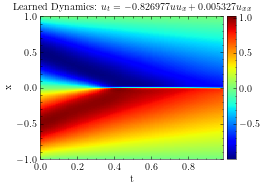

In [20]:
fig, ax = plt.subplots(1, 1)

h = ax.imshow(uf.reshape(X.shape).T, interpolation='nearest', cmap='jet', 
          extent=[lb[1], ub[1], lb[0], ub[0]], 
          origin='lower', aspect='auto')

ax.set_title("Learned Dynamics: $u_t = -0.826977uu_{x}+0.005327u_{xx}$", fontsize = 10)
ax.set_xlabel('t')
ax.set_ylabel('x')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig("./vis_pics/Learned_Dynamics_noisyxt_noisylabels_1stage_V2.png", dpi=300)
plt.show()

In [21]:
# No selector network (Not the same as setting lambda_1 to 0.0) 
# varying lambda_{1} | lambda_{0} = 1e-5 or 1e-6 (the same results anyway)
# PDE derived using STRidge
# u_t = (0.002543 +0.000000i)u_xx
#     + (-0.832252 +0.000000i)uf*u_x

# 1e-1
# tensor([0.2735, 0.1883, 0.2060, 0.2133])
# u_t = (0.002695 +0.000000i)u_xx
#     + (-0.924525 +0.000000i)uf*u_x

# 1e-3
# tensor([0.8153, 0.8142, 0.4398, 0.1562])
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

# 1e-5
# tensor([0.6721, 0.7903, 0.7139, 0.3486])
# u_t = (0.002594 +0.000000i)u_xx
#     + (-0.885143 +0.000000i)uf*u_x

# varying lambda_{0} | lambda_{1} = 1e-3
# 1e-1
# PDE derived using STRidge
# u_t = (-0.066179 +0.000000i)uf*u_x

# 1e-3
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

# 1e-5
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

In [22]:
# Goals!!!
# 3000 | eq found by STR | eq after PINN fine-tuning + mean error
# 1000 | eq found by STR | eq after PINN fine-tuning + mean error
# 500 | eq found by STR | eq after PINN fine-tuning + mean error

# 3000
# eq found by STR 
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x
# eq after PINN fine-tuning + mean error
# (-0.9994307160377502, 0.0031862353649783444)
# (0.07773227423228249, )

# 1000
# eq found by STR
# u_t = (0.002631 +0.000000i)u_xx
#     + (-0.860374 +0.000000i)uf*u_x
# eq after PINN fine-tuning + mean error
# (-0.9891335368156433, 0.0031485233921557665)
# (1.0864333669569826, 0.0002129514786863851)

# 500
# eq found by STR (failed)
# u_t = (-0.072116 +0.000000i)uf*u_x

In [23]:
# Clean all
# [0.8153, 0.8142, 0.4398, 0.1562]
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

# Clean (x, t), and noisy labels
# [0.7840, 0.7994, 0.4154, 0.2193]
# u_t = (0.002942 +0.000000i)u_xx
#     + (-0.961846 +0.000000i)uf*u_x

# Noisy (x, t), and noisy labels
# [0.7423, 0.7245, 0.6249, 0.2471]
# u_t = (0.005327 +0.000000i)u_xx
#     + (-0.826977 +0.000000i)uf*u_x